# Chapter 2 - Univariate Returns

In [1]:
%load_ext autoreload
%autoreload 2

## Load S&P 500 Data

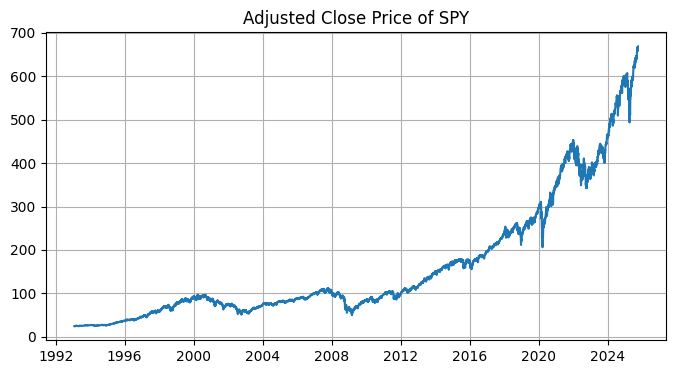

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def load_data():
    spx = yf.Ticker("SPY")
    hist = spx.history(start="1950-01-01", interval="1d", auto_adjust=False)
    return hist
data = load_data()
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.plot(data["Adj Close"])
ax.set_title("Adjusted Close Price of SPY")
ax.grid()

## 2.1 Returns

## Return Definitions

**Return** is defined as:

$$r\left(1\right) := \frac{P\left(1\right) + D\left(1\right) - P\left(0\right)}{P\left(0\right)}$$

Where $P\left(t\right)$ is the price at time $t$ and $D\left(t\right)$ is the dividend (if any) at time $t$

**Excess Return** is defined as $r - r_f$ where $r_f$ is the risk free rate e.g. Secured Overnight Financing Rate (SOFR)

**Log Return** is defined as 

$$\tilde{r}_1 := \log\left(1+r_1\right)$$

## Return vs. Log Return

Three key points:

- Returns compounds to calculate cumulative returns, the distribution diverges from normal distribution when the single period return is close to normal distribution.

- On the other hand, log returns are additive over time, the distribution doesn't diverge much from normal distribution.

- By Taylor expansion, we get $\tilde{r} = r + o\left({\left|r\right|}^2\right)$. If $r$ is small, then $\tilde{r} \simeq r$. For daily interval measurement or shorter, the approximation is good. Therefore, longer period measurement may result in poor appoximation.

<span style="color:red;">However, from the test below, it seems log returns drift more away from normal distribution than returns. Maybe it's because the daily log returns and returns aren't normally distributed to start with?</span>

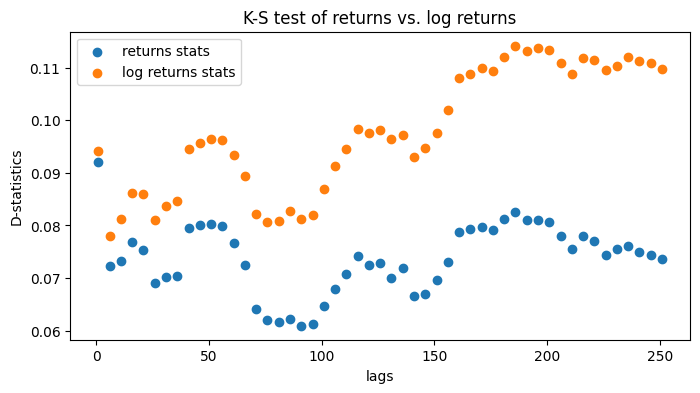

In [2]:
def calc_return(price, periods):
    return price[periods:] / price[:-periods] - 1

def calc_log_return(price, periods):
    return np.log(price[periods:] / price[:-periods])

def plot_hist_kde(data, ax):
    sns.kdeplot(data, linewidth=2, ax=ax)
    return ax
    

from scipy.stats import shapiro, kstest
import numpy as np

returns_stats = []
log_returns_stats = []
for lag in range(1, 252, 5):
    returns = calc_return(data["Adj Close"].values, lag)
    log_returns = calc_log_return(data["Adj Close"].values, lag)
    returns_stat, _ = kstest(returns, "norm", args=(np.mean(returns), np.std(returns)))
    log_returns_stat, _ = kstest(log_returns, "norm", args=(np.mean(log_returns), np.std(log_returns)))
    returns_stats.append(returns_stat)
    log_returns_stats.append(log_returns_stat)

fig, ax = plt.subplots(1, figsize=(8,4))
ax.scatter(np.arange(1, 252, 5), returns_stats, label="returns stats")
ax.scatter(np.arange(1, 252, 5), log_returns_stats, label="log returns stats")
ax.set_xlabel("lags")
ax.set_ylabel("D-statistics")
ax.set_title("K-S test of returns vs. log returns")
ax.legend()

Let's try a toy model with log returns generated by the normal distribution $N(0, 0.01)$

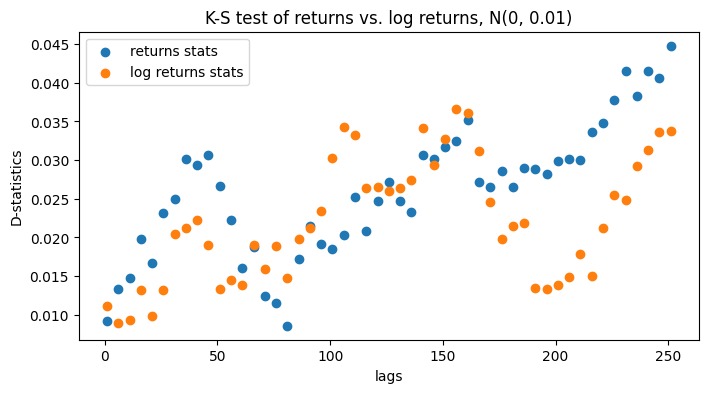

In [3]:
sim_log_returns = np.random.randn(5000)/100
sim_price = np.exp(np.cumsum(sim_log_returns))

returns_stats = []
log_returns_stats = []
for lag in range(1, 252, 5):
    returns = calc_return(sim_price, lag)
    log_returns = calc_log_return(sim_price, lag)
    returns_stat, _ = kstest(returns, "norm", args=(np.mean(returns), np.std(returns)))
    log_returns_stat, _ = kstest(log_returns, "norm", args=(np.mean(log_returns), np.std(log_returns)))
    returns_stats.append(returns_stat)
    log_returns_stats.append(log_returns_stat)

fig, ax = plt.subplots(1, figsize=(8,4))
ax.scatter(np.arange(1, 252, 5), returns_stats, label="returns stats")
ax.scatter(np.arange(1, 252, 5), log_returns_stats, label="log returns stats")
ax.set_xlabel("lags")
ax.set_ylabel("D-statistics")
ax.set_title("K-S test of returns vs. log returns, N(0, 0.01)")
ax.legend()

Let's try another toy model with log returns generated by the normal distribution $N(0, 0.1)$

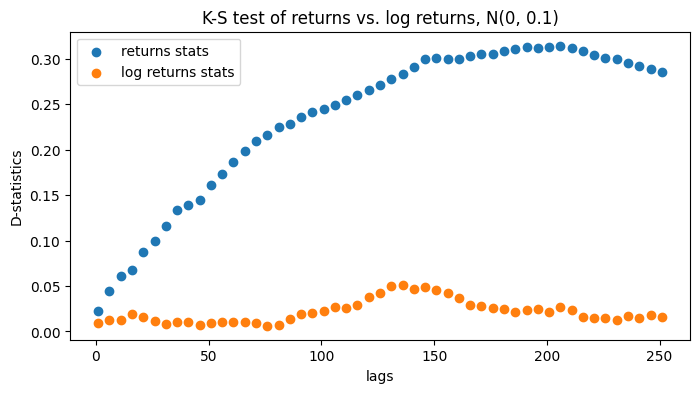

In [4]:
sim_log_returns = np.random.randn(5000)/10
sim_price = np.exp(np.cumsum(sim_log_returns))

returns_stats = []
log_returns_stats = []
for lag in range(1, 252, 5):
    returns = calc_return(sim_price, lag)
    log_returns = calc_log_return(sim_price, lag)
    returns_stat, _ = kstest(returns, "norm", args=(np.mean(returns), np.std(returns)))
    log_returns_stat, _ = kstest(log_returns, "norm", args=(np.mean(log_returns), np.std(log_returns)))
    returns_stats.append(returns_stat)
    log_returns_stats.append(log_returns_stat)

fig, ax = plt.subplots(1, figsize=(8,4))
ax.scatter(np.arange(1, 252, 5), returns_stats, label="returns stats")
ax.scatter(np.arange(1, 252, 5), log_returns_stats, label="log returns stats")
ax.set_xlabel("lags")
ax.set_ylabel("D-statistics")
ax.set_title("K-S test of returns vs. log returns, N(0, 0.1)")
ax.legend()

Quote from section 2.1.3, page 24 "For long time intervals or very volatile returns, the approximation is poor". Log returns are more or less in line with returns's test stat as they both drift away from normal distribution with longer intervals when volatility is relatively low in N(0, 0.01). However, when switched to N(0, 0.1), returns start drifting a lot quickly compared to log returns. 

**To sum up, returns and log returns can be used interchangeably IF the volatility if low, otherwise, always use log returns.**

### 2.1.4 Estimating Prices and Returns

Due to various measurement errors, taking the exponential moving average may help discover the true price. According to Roll model

$$m_{t+1} = m_t + \sigma_{\epsilon}\epsilon_{t+1}$$
$$p_{t+1} = m_{t+1} + \sigma_{\eta}\eta_{t+1}$$

Where $\epsilon$ and $\eta$ are from standard normal distributions (indepent serially and to each other). The exponential moving average is

$$\hat{m_{t+1}} = \left(1-K\right)\hat{m_{t}} + Kp_t$$

Key points (both are tested below):
- **This relationship makes sense, higher variance ratio -> noisier price series -> more aggresive averaging with EMA -> smaller K, vice versa.**
- **When using EMA on price series, make sure that the K is sufficiently large so that the long term memory doesn't persist too much that estimates become positively correlated.**


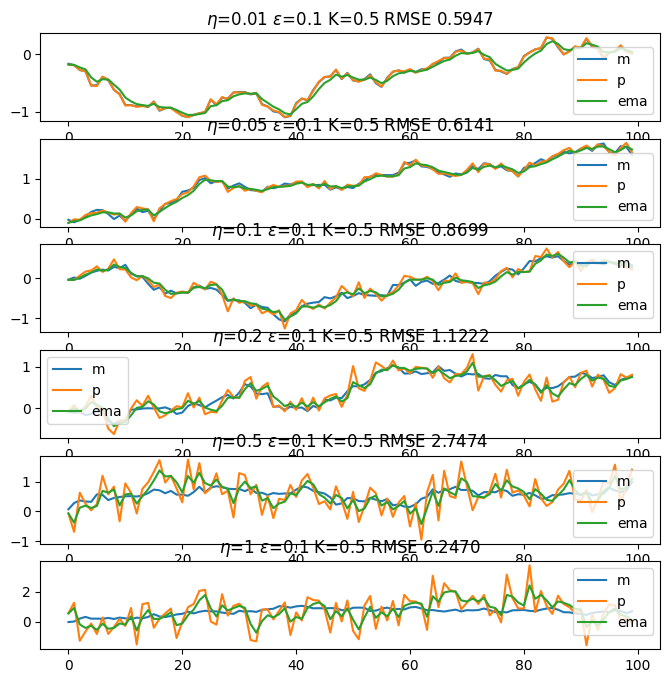

In [5]:
n = 100

sigma_eta = 0.2
sigma_epsilon = 0.1
sigma_etas = [0.01, 0.05, 0.1, 0.2, 0.5, 1]
sigma_epsilon = 0.1
K = 0.5

fig, axes = plt.subplots(len(sigma_etas), figsize=(8,8))

for i, sigma_eta in enumerate(sigma_etas):
    m = np.cumsum(np.random.randn(n) * sigma_epsilon)
    p = m + np.random.randn(n) * sigma_eta
    ema = [p[0]]
    for j in range(1, n):
        ema.append((1-K)*ema[j-1] + K*p[j])
    ema = np.array(ema)
    rmse = np.sqrt(np.sum((ema-m)**2))
    
    axes[i].plot(m, label="m")
    axes[i].plot(p, label="p")
    axes[i].plot(ema, label="ema")
    axes[i].set_title(f"$\eta$={sigma_eta} $\epsilon$={sigma_epsilon} K={K} RMSE {rmse:.4f}")
    axes[i].legend()


In [6]:
n = 100

sigma_eta = 1
sigma_epsilon = 0.1
m = np.cumsum(np.random.randn(n) * sigma_epsilon)
p = m + np.random.randn(n) * sigma_eta
Ks = [0.1, 0.5, 0.9]
for K in Ks:
    ema = [p[0]]
    for j in range(1, n):
        ema.append((1-K)*ema[j-1] + K*p[j])
    ema = np.array(ema)
    
    p_acf1 = ((p[1:]-np.mean(p[1:])) @ (p[:-1]-np.mean(p[:-1]))) / np.sum((p-np.mean(p))**2)
    ema_acf1 = ((ema[1:]-np.mean(ema[1:])) @ (ema[:-1]-np.mean(ema[:-1]))) / np.sum((ema-np.mean(ema))**2)
    
    print(f"K {K}, price autocorr {p_acf1:.2f}, ema autocorr {ema_acf1:.2f}")

K 0.1, price autocorr 0.00, ema autocorr 0.91
K 0.5, price autocorr 0.00, ema autocorr 0.52
K 0.9, price autocorr 0.00, ema autocorr 0.10


### 2.1.5 Stylized facts

As explained above, log returns will be used going forward. There are 4 facts:
- Absence of autocorrelations
  - <span style="color:red;">There does seem to be a negative autocorr at lag 1 (>95% confidence) though </span>
- Heavy tails
  - SPY kurtosis is consistent with table 2.1
- Autocorrelation of absolute returns and second moments
  - Significant positive autocorr, suggesting vol clustering
- Aggregational Gaussianity, longer time scale (monthly vs. daily) log-returns become closer to Gaussian distribution.
  - <span style="color:red;"> as seen in the earlier section, my finding is that longer time scale actually drifts away from Gaussian distribution </span>
  - If just comparing kurtosis and skewness, longer time scale does seem to result in thinner tails and more left skewed.

Since returns have heavy tails, power-tailed distributions are used and the tail index $\alpha=4$. This is important as the power-tail random variables only have finite moments up to $\alpha$. 
So to be able to estimate the volaility of returns $E\left(r^2\right)$, we need to make sure that $E\left(r^4\right)$ is finite due to CLT.

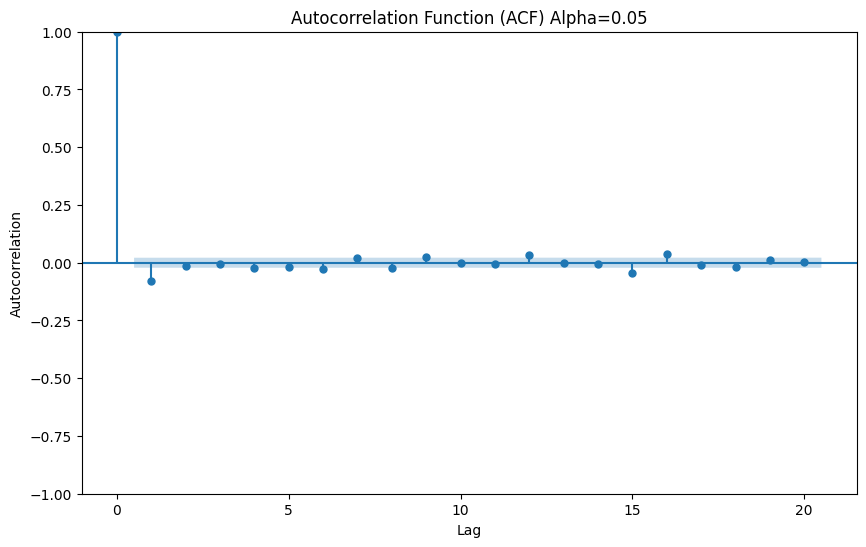

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

returns = calc_log_return(data["Adj Close"].values, 1)
# Absence of autocorrelations
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(returns, lags=20, ax=ax, alpha=0.05)
plt.title('Autocorrelation Function (ACF) Alpha=0.05')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

In [40]:
# measurement kurtosis with non-parametric bootstrap
from scipy.stats import kurtosis, skew

def bootstrap_kurtosis(returns):
    kurt_measures = []
    n = int(len(returns) * 0.5)
    for _ in range(5000):
        kurt_measures.append(kurtosis(np.random.choice(returns, size=n, replace=True)))
    mean_kurt = np.mean(kurt_measures)
    lower_kurt = np.percentile(kurt_measures, 100 * 0.01)
    upper_kurt = np.percentile(kurt_measures, 100 * 0.99)
    return mean_kurt, lower_kurt, upper_kurt

def bootstrap_skew(returns):
    skew_measures = []
    n = int(len(returns) * 0.5)
    for _ in range(5000):
        skew_measures.append(skew(np.random.choice(returns, size=n, replace=True)))
    mean_skew = np.mean(skew_measures)
    lower_skew = np.percentile(skew_measures, 100 * 0.01)
    upper_skew = np.percentile(skew_measures, 100 * 0.99)
    return mean_skew, lower_skew, upper_skew
    
returns = calc_log_return(data["Adj Close"].values, 1)
mean_kurt, lower_kurt, upper_kurt = bootstrap_kurtosis(returns)
print(f"mean kurt: {mean_kurt:.2f}, {lower_kurt:.2f} - {upper_kurt:.2f}")


mean kurt: 11.12, 5.47 - 18.75


Text(0, 0.5, 'Autocorrelation')

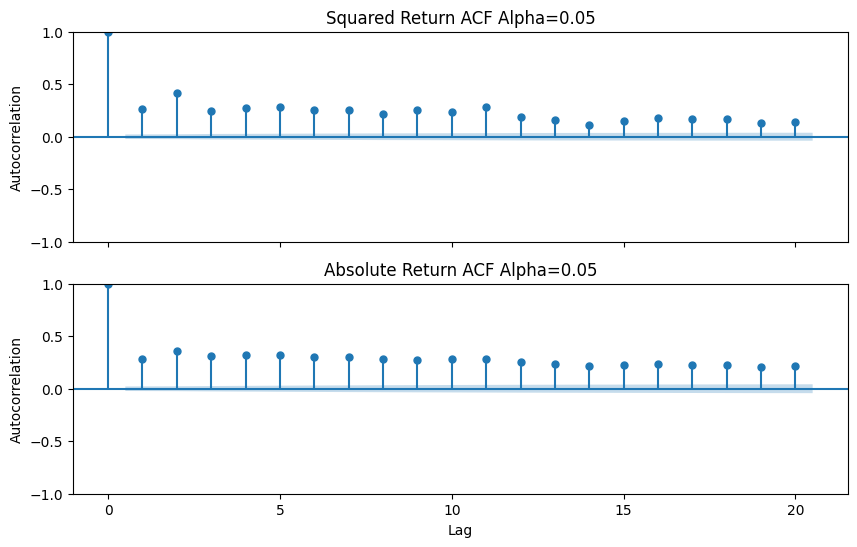

In [35]:
# ACF of squared and absolute returns

returns = calc_log_return(data["Adj Close"].values, 1)
# Absence of autocorrelations
fig, axes = plt.subplots(2, figsize=(10, 6), sharex=True)
plot_acf(returns**2, lags=20, ax=axes[0], alpha=0.05)
axes[0].set_title('Squared Return ACF Alpha=0.05')
axes[0].set_ylabel('Autocorrelation')

plot_acf(np.abs(returns), lags=20, ax=axes[1], alpha=0.05)
axes[1].set_title('Absolute Return ACF Alpha=0.05')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')


In [42]:
# compare kurtosis of daily and monthly returns

returns = calc_log_return(data["Adj Close"].values, 1)
mean_kurt, lower_kurt, upper_kurt = bootstrap_kurtosis(returns)
mean_skew, lower_skew, upper_skew = bootstrap_skew(returns)
print(f"delta=1")
print(f"\tmean kurt: {mean_kurt:.2f}, {lower_kurt:.2f} - {upper_kurt:.2f}")
print(f"\tmean skew: {mean_skew:.2f}, {lower_skew:.2f} - {upper_skew:.2f}")

returns = calc_log_return(data["Adj Close"].values, 20)
mean_kurt, lower_kurt, upper_kurt = bootstrap_kurtosis(returns)
mean_skew, lower_skew, upper_skew = bootstrap_skew(returns)
print(f"delta=20")
print(f"\tmean kurt: {mean_kurt:.2f}, {lower_kurt:.2f} - {upper_kurt:.2f}")
print(f"\tmean skew: {mean_skew:.2f}, {lower_skew:.2f} - {upper_skew:.2f}")

returns = calc_log_return(data["Adj Close"].values, 252)
mean_kurt, lower_kurt, upper_kurt = bootstrap_kurtosis(returns)
mean_skew, lower_skew, upper_skew = bootstrap_skew(returns)
print(f"delta=252")
print(f"\tmean kurt: {mean_kurt:.2f}, {lower_kurt:.2f} - {upper_kurt:.2f}")
print(f"\tmean skew: {mean_skew:.2f}, {lower_skew:.2f} - {upper_skew:.2f}")

delta=1
	mean kurt: 11.16, 5.45 - 18.36
	mean skew: -0.25, -1.17 - 0.80
delta=20
	mean kurt: 6.92, 3.93 - 10.11
	mean skew: -1.35, -1.81 - -0.88
delta=252
	mean kurt: 2.17, 1.76 - 2.59
	mean skew: -1.22, -1.33 - -1.11
